In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F

In [2]:
batch_size, num_steps = 32, 35

In [3]:
#!curl --output pap.txt https://www.gutenberg.org/files/1342/1342-0.txt

In [4]:
from d2l import torch as d2l

In [5]:
import re

d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt','090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine(): #@save
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()


In [6]:
import re
def read_text(text_name='pap.txt'):
    with open(text_name, 'r', encoding='utf-8') as text_input:
        lines = text_input.readlines()
    
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines] # only alphabets

In [7]:
text_input = read_text()

In [8]:
text_input = read_time_machine()

In [9]:
text_input[:5]

['the time machine by h g wells', '', '', '', '']

In [10]:
def tokenize(lines, token_type='word'):
    if token_type == 'char':
        return [list(line) for line in lines]
    elif token_type == 'word':
        return [line.split() for line in lines]
    else:
        'Wrong token type.'

In [11]:
import collections

def count_corpus(tokens):
    tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [12]:
# Defined in file: ./chapter_recurrent-neural-networks/text-preprocessing.md
class Vocab:
    def __init__(self, tokens=None,min_freq=0):
        if tokens == None:
            tokens = []
        
        tokens = [token for line in tokens for token in line]
        counter = collections.Counter(tokens)
        
        self._token_freqs = sorted(counter.items(),key=lambda x:x[1], reverse=True)
        self.idx_to_token = ['<unk>']
        self.token_to_idx = { token:idx for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                #print(f"for {freq} : {token} breaking")
                continue
            elif token not in self.idx_to_token:
                #print(token + "adding")
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token)-1
            else:
                print(token + " found already")
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if isinstance(tokens, list):
            return_list = []
            for t in tokens:
                for token in t:
                    if token in self.token_to_idx.keys():
                        return_list.append(self.token_to_idx[token])
                    else:
                        return_list.append(self.unk)
            return return_list
        else:
            if tokens in self.token_to_idx.keys():
                return self.token_to_idx[tokens]
            else:
                return self.unk
            
    def to_tokens(self, indices):
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Index for the unknown token
        return self._token_freqs


In [13]:
tokens = tokenize(text_input)
tokens[:1]

[['the', 'time', 'machine', 'by', 'h', 'g', 'wells']]

In [14]:
# tokens = [token for line in tokens for token in line]
# tokens[:5]

In [15]:
vocab = Vocab(tokens)

In [16]:
for i in vocab.token_freqs:
    if i[0] == 'the':
        print(i)
# print(vocab.token_freqs)
# vocab.token_to_idx

# the error is that we are using the entire sentece for creating token
# problem in tokenize

('the', 2261)


In [17]:
vocab['the']

1

In [18]:
vocab.token_freqs[:5]

[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816)]

In [19]:
def load_corpus(max_tokens=-1, text_input=text_input):
    tokens = tokenize(text_input)
    vocab = Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
    

In [20]:
corpus, vocab = load_corpus()

In [56]:
class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else :
            self.data_iter_fn = seq_data_iter_sequential
        
        self.corpus, self.vocab = load_corpus(max_tokens=max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [57]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    print("Dont use random seq data iter")

In [58]:
import random
num_steps = 5
batch_size=5
offset = random.randint(0, num_steps)
    
print(offset)

4


In [59]:
len(corpus)-offset-1

32770

In [60]:
num_tokens = (len(corpus) -offset -1)//batch_size * batch_size # ensuring num_tokens is perfectly divisible
num_tokens

32770

In [61]:
Xs = torch.tensor(corpus[offset:offset+num_tokens])
len(Xs),Xs[:5]

(32770, tensor([2183, 2184,  400,    2,    1]))

In [62]:
Ys = torch.tensor(corpus[offset+1:offset+1+num_tokens])
len(Ys),Ys[:5]

(32770, tensor([2184,  400,    2,    1,   19]))

In [63]:
Xs = Xs.reshape(batch_size,-1)
len(Xs), Xs[:5]

# okay Xs devided into 5 batches

(5,
 tensor([[2183, 2184,  400,  ...,  745,   72,   42],
         [ 510,    6, 1651,  ...,   29,  246,  160],
         [  22,  115,  200,  ...,   16,    1, 1378],
         [   4,    1,  105,  ...,  504, 4128,   16],
         [  54,  756,   53,  ...,    1, 1012,    4]]))

In [64]:
num_batches = Xs.shape[1]//num_steps
num_batches

# these many times we will go through the sequence

1310

In [65]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus)-offset-1)//batch_size)*batch_size
    
    Xs = torch.tensor(corpus[offset:offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1:offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1]//num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        Xs = Xs[i:i+num_steps]
        Ys = Ys[i:i+num_steps]
        yield X, Y
    
    

In [66]:
def load_data(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    
    return data_iter, data_iter.vocab

In [67]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data(batch_size, num_steps)

In [156]:
#trying the book way

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

book way is working fine showing that there is some error in tokenisation.

In [157]:
# one hot encoding

F.one_hot(torch.tensor([0,2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [158]:
X = torch.arange(10).reshape((2,5))
F.one_hot(X.T, 28,).shape

torch.Size([5, 2, 28])

In [159]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### RNN Model
To define an RNN model, we first need an init_rnn_state function to return the hidden state at
initialization. It returns a tensor filled with 0 and with a shape of (batch size, number of hidden
units). Using tuples makes it easier to handle situations where the hidden state contains multiple
variables, which we will encounter in later sections

In [160]:
# returns a torch of zeros
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [161]:
H, = init_rnn_state(2, 512, torch.device('cuda'))

## init state is suppposed to return a tuple so handle accordingly

In [162]:
H.shape

torch.Size([2, 512])

In [163]:
H = init_rnn_state(2,512, torch.device('cuda'))

In [164]:
H

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),)

The following rnn function defines how to compute the hidden state and output at a time step.
Note that the RNN model loops through the outermost dimension of inputs so that it updates
hidden states H of a minibatch, time step by time step. Besides, the activation function here uses
the tanh function. As described in Section 4.1, the mean value of the tanh function is 0, when the
elements are uniformly distributed over the real numbers.

In [165]:
def rnn(inputs, state, params):
# Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
# Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)


With all the needed functions being defined, next we create a class to wrap these functions and
store parameters for an RNN model implemented from scratch.

In [166]:
class RNNModelScratch:
    def __init__(self, vocab_size, hidden_size,device, get_params, init_state,forward_fn):
        self.vocab_size, self.hidden_size = vocab_size, hidden_size
        self.forward_fn = forward_fn
        self.init_state = init_state
        self.params = get_params(vocab_size, hidden_size, device)
    
    def __call__(self,X, state ):
        #print(X.shape)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        #print(X.shape)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self,batch_size, device):
        return self.init_state(batch_size, self.hidden_size, device)

Let us check whether the outputs have the correct shapes, e.g., to ensure that the dimensionality
of the hidden state remains unchanged

In [167]:
X, X.shape[0]

(tensor([[0, 1, 2, 3, 4],
         [5, 6, 7, 8, 9]]),
 2)

https://towardsdatascience.com/illustrated-guide-to-recurrent-neural-networks-79e5eb8049c9

In [168]:
#checking if output gave fixd dusze
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, torch.device('cuda'), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], torch.device('cuda'))
Y,new_state = net(X.to(torch.device('cuda')), state)

In [169]:
Y.shape, len(new_state), new_state[0].shape

#We can see that the output shape is (number of time steps × batch size, vocabulary size), 
#while the hidden state shape remains the same, i.e., (batch size, number of hidden units).


(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number of time steps × batch size, vocabulary size), while the
hidden state shape remains the same, i.e., (batch size, number of hidden units).


Let us first define the prediction function to generate new characters following the user-provided
prefix, which is a string containing several characters. When looping through these beginning
characters in prefix, we keep passing the hidden state to the next time step without generating
any output. This is called the warm-up period, during which the model updates itself (e.g., update
the hidden state) but does not make predictions. After the warm-up period, the hidden state is
generally better than its initialized value at the beginning. So we generate the predicted characters
and emit them

In [170]:
def predict_ch8(prefix,num_preds, net, vocab,device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))
    for y in prefix[1:]:
        #print(get_input())
        _,state = net(get_input(),state)
        outputs.append(vocab[y])
    
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
    

In [171]:
predict_ch8('timess traveller ', 10, net, vocab, d2l.try_gpu())
# generating the same output everytime 

'timess traveller ubdt erft '

In [172]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameter() if p.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    
    if norm>theta:
        for param in params:
            param.grad[:] *= theta /norm


In [177]:
import math
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [178]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

perplexity 1.0, 61217.6 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


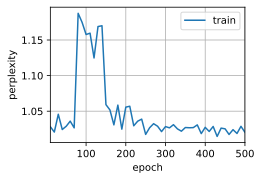

In [179]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

### Exercises
### for doing this i need to understand from scratch
1. Show that one-hot encoding is equivalent to picking a different embedding for each object.
2. Adjust the hyperparameters (e.g., number of epochs, number of hidden units, number of
time steps in a minibatch, and learning rate) to improve the perplexity.
• How low can you go?
• Replace one-hot encoding with learnable embeddings. Does this lead to better performance?
• How well will it work on other books by H. G. Wells, e.g., The War of the Worlds106?
3. Modify the prediction function such as to use sampling rather than picking the most likely
next character.
• What happens?
• Bias the model towards more likely outputs, e.g., by sampling from q(xt
|
xt−1, . . . , x1) ∝ P(xt
| xt−1, . . . , x1)
α for α > 1.
4. Run the code in this section without clipping the gradient. What happens?
5. Change sequential partitioning so that it does not separate hidden states from the computational graph. Does the running time change? How about the perplexity?
6. Replace the activation function used in this section with ReLU and repeat the experiments
in this section. Do we still need gradient clipping? Why?